In [2]:
future_days = 1
horizon = int(96*future_days)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
utility_data=pd.read_csv('weatherkit_plus_load.csv')

In [5]:
utility_data.event_timestamp = utility_data.event_timestamp.apply(pd.to_datetime)

In [6]:
# reduce data size to save time on tuning
utility_data = utility_data.iloc[int(utility_data.shape[0]/2):] 

In [7]:
utility_data.event_timestamp.min()

Timestamp('2023-04-27 01:00:00+0530', tz='pytz.FixedOffset(330)')

In [8]:
utility_data.event_timestamp.max()

Timestamp('2023-07-10 17:00:00+0530', tz='pytz.FixedOffset(330)')

In [9]:
utility_data['ts_month_of_year'] = utility_data.event_timestamp.apply(lambda x : x.month)

In [10]:
utility_data['ts_day_of_month'] = utility_data.event_timestamp.apply(lambda x : x.day)

In [11]:
utility_data['ts_day_of_week'] = utility_data.event_timestamp.apply(lambda x : x.dayofweek)

In [12]:
utility_data['ts_hour_of_day'] = utility_data.event_timestamp.apply(lambda x : x.hour)

In [13]:
utility_data['ts_minute_of_hour'] = utility_data.event_timestamp.apply(lambda x : x.minute)

In [14]:
utility_data.head()

,event_timestamp,weatherkit_observed_temperature_C,weatherkit_observed_humidity_pc,weatherkit_observed_air_pressure_kPa,weatherkit_observed_cloud_cover_pc,weatherkit_observed_wind_direction_deg,weatherkit_observed_wind_speed_km_h,weatherkit_forecast_temp_C,weatherkit_forecast_humidity_pc,weatherkit_forecast_air_pressure_kPa,weatherkit_forecast_cloud_cover_pc,weatherkit_forecast_wind_direction_deg,weatherkit_forecast_wind_speed_km_h,load_MW,ts_month_of_year,ts_day_of_month,ts_day_of_week,ts_hour_of_day,ts_minute_of_hour
7149,2023-04-27 01:00:00+05:30,27.59,77.0,100.856,70.0,253.0,3.15,27.26,78.0,100.883,47.0,244.0,4.96,312.543560,4,27,3,1,0
7150,2023-04-27 01:15:00+05:30,27.50,77.0,100.841,72.0,252.0,2.84,27.26,78.0,100.883,47.0,244.0,4.96,307.250875,4,27,3,1,15
7151,2023-04-27 01:30:00+05:30,27.42,77.0,100.827,73.0,251.0,2.71,26.75,79.0,100.832,43.0,234.0,4.73,305.648932,4,27,3,1,30
7152,2023-04-27 01:45:00+05:30,27.33,77.0,100.814,72.0,252.0,2.56,26.75,79.0,100.832,43.0,234.0,4.73,301.524402,4,27,3,1,45
7153,2023-04-27 02:00:00+05:30,27.22,78.0,100.803,71.0,253.0,2.44,26.75,79.0,100.832,43.0,234.0,4.73,295.448069,4,27,3,2,0


In [15]:
target_var = 'load_MW'

In [16]:
predictor_variables = [col for col in utility_data.columns if col not in ['event_timestamp',target_var]]
predictor_variables

['weatherkit_observed_temperature_C',
 'weatherkit_observed_humidity_pc',
 'weatherkit_observed_air_pressure_kPa',
 'weatherkit_observed_cloud_cover_pc',
 'weatherkit_observed_wind_direction_deg',
 'weatherkit_observed_wind_speed_km_h',
 'weatherkit_forecast_temp_C',
 'weatherkit_forecast_humidity_pc',
 'weatherkit_forecast_air_pressure_kPa',
 'weatherkit_forecast_cloud_cover_pc',
 'weatherkit_forecast_wind_direction_deg',
 'weatherkit_forecast_wind_speed_km_h',
 'ts_month_of_year',
 'ts_day_of_month',
 'ts_day_of_week',
 'ts_hour_of_day',
 'ts_minute_of_hour']

In [17]:
observed_vars = [col for col in predictor_variables if 'observed' in col]
observed_vars

['weatherkit_observed_temperature_C',
 'weatherkit_observed_humidity_pc',
 'weatherkit_observed_air_pressure_kPa',
 'weatherkit_observed_cloud_cover_pc',
 'weatherkit_observed_wind_direction_deg',
 'weatherkit_observed_wind_speed_km_h']

In [18]:
forecast_vars = [col for col in predictor_variables if 'forecast' in col] # or 'ts_' in col)]
forecast_vars

['weatherkit_forecast_temp_C',
 'weatherkit_forecast_humidity_pc',
 'weatherkit_forecast_air_pressure_kPa',
 'weatherkit_forecast_cloud_cover_pc',
 'weatherkit_forecast_wind_direction_deg',
 'weatherkit_forecast_wind_speed_km_h']

In [19]:
ts_vars = [col for col in predictor_variables if 'ts_' in col]
ts_vars

['ts_month_of_year',
 'ts_day_of_month',
 'ts_day_of_week',
 'ts_hour_of_day',
 'ts_minute_of_hour']

In [20]:
target_var

'load_MW'

In [21]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.model_selection import train_test_split
from src.tde import time_delay_embedding
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

MAPE = []
RMSE = []
MAE = []
n_lags_out = []
n_est_out = []
n_lags_set = [1,2,3,7,10,14]
n_estimators_set = [10,25,50,100]
for n_lags in n_lags_set:
    for n_estimators in n_estimators_set:
        print('Training a model with {} lages and {} n_estimators'.format(n_lags,n_estimators))
        # create data set with lagged features using time delay embedding
        utility_data_ds = []
        for col in utility_data.columns:
            if col in observed_vars: 
                col_df = time_delay_embedding(utility_data[col], n_lags=n_lags, horizon=0)
                utility_data_ds.append(col_df.copy())
            elif col in forecast_vars: 
                col_df = time_delay_embedding(utility_data[col], n_lags=n_lags, horizon=horizon)
                utility_data_ds.append(col_df.copy())
            elif col in ts_vars: 
                col_df = utility_data[col]
                utility_data_ds.append(col_df.copy())
            elif col in [target_var]:
                col_df = time_delay_embedding(utility_data[col], n_lags=n_lags, horizon=horizon)
                utility_data_ds.append(col_df.copy())

        # concatenating all variables
        utility_data_df = pd.concat(utility_data_ds, axis=1).dropna()

        target_variables = utility_data_df.columns.str.contains(f'{target_var}\(t\+')
        target_variables = utility_data_df.columns[target_variables]

        predictor_variables = [col for col in utility_data_df.columns if col not in target_variables]

        # defining target (Y) and explanatory variables (X)
        X = utility_data_df[predictor_variables]
        Y = utility_data_df[target_variables]

        # get month-day for data splitting
        month_days = X.ts_month_of_year.astype(str)+'-'+X.ts_day_of_month.astype(str)

        # train/test split
        days_tr_val,_ = train_test_split(month_days.unique(), test_size=14, shuffle=False)
        days_tr,days_val = train_test_split(days_tr_val, test_size=14, shuffle=False)
        train_msk = month_days.isin(days_tr)
        val_msk = month_days.isin(days_val)
        X_tr, X_val  = X[train_msk],X[val_msk]
        Y_tr, Y_val = Y[train_msk],Y[val_msk]

        # fitting a lgbm model without feature engineering
        model_wo_fe = MultiOutputRegressor(LGBMRegressor(n_estimators = n_estimators),n_jobs=3)
        model_wo_fe.fit(X_tr, Y_tr)

        # get validation performance
        preds_val = model_wo_fe.predict(X_val)
        MAPE.append(mape(Y_val, preds_val))
        RMSE.append(np.sqrt(mse(Y_val, preds_val)))
        MAE.append(mae(Y_val, preds_val))
        n_lags_out.append(n_lags)
        n_est_out.append(n_estimators)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training a model with 1 lages and 10 n_estimators
Training a model with 1 lages and 25 n_estimators
Training a model with 1 lages and 50 n_estimators
Training a model with 1 lages and 100 n_estimators
Training a model with 2 lages and 10 n_estimators
Training a model with 2 lages and 25 n_estimators
Training a model with 2 lages and 50 n_estimators
Training a model with 2 lages and 100 n_estimators
Training a model with 3 lages and 10 n_estimators
Training a model with 3 lages and 25 n_estimators
Training a model with 3 lages and 50 n_estimators
Training a model with 3 lages and 100 n_estimators
Training a model with 7 lages and 10 n_estimators
Training a model with 7 lages and 25 n_estimators
Training a model with 7 lages and 50 n_estimators
Training a model with 7 lages and 100 n_estimators
Training a model with 10 lages and 10 n_estimators
Training a model with 10 lages and 25 n_estimators
Traini

In [22]:
tune_res = pd.DataFrame({'n_lages':n_lags_out,'n_estimators':n_est_out,'MAPE':MAPE,'RMSE':RMSE,'MAE':MAE})
tune_res

,n_lages,n_estimators,MAPE,RMSE,MAE
0,1,10,0.098256,54.107688,42.736853
1,1,25,0.078908,46.329445,33.940688
2,1,50,0.080077,47.620882,34.166248
3,1,100,0.082689,48.894715,35.022656
4,2,10,0.098172,54.027974,42.610728
5,2,25,0.079181,46.492275,34.048800
6,2,50,0.081021,48.134343,34.579206
7,2,100,0.083701,49.488752,35.466960
8,3,10,0.097865,53.765649,42.440405
9,3,25,0.080112,47.193574,34.445922


In [23]:
tune_res.sort_values(by='MAPE')

,n_lages,n_estimators,MAPE,RMSE,MAE
1,1,25,0.078908,46.329445,33.940688
5,2,25,0.079181,46.492275,34.048800
2,1,50,0.080077,47.620882,34.166248
9,3,25,0.080112,47.193574,34.445922
6,2,50,0.081021,48.134343,34.579206
10,3,50,0.081671,49.178032,34.875798
13,7,25,0.081754,48.313116,35.065187
17,10,25,0.082066,48.575547,35.136741
3,1,100,0.082689,48.894715,35.022656
7,2,100,0.083701,49.488752,35.466960


In [24]:
# increasing the resolution around the area where the accuracy was the best

%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.model_selection import train_test_split
from src.tde import time_delay_embedding
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

MAPE = []
RMSE = []
MAE = []
n_lags_out = []
n_est_out = []
n_lags_set = [1,2]
n_estimators_set = [15,20,30,45]
for n_lags in n_lags_set:
    for n_estimators in n_estimators_set:
        print('Training a model with {} lages and {} n_estimators'.format(n_lags,n_estimators))
        # create data set with lagged features using time delay embedding
        utility_data_ds = []
        for col in utility_data.columns:
            if col in observed_vars: 
                col_df = time_delay_embedding(utility_data[col], n_lags=n_lags, horizon=0)
                utility_data_ds.append(col_df.copy())
            elif col in forecast_vars: 
                col_df = time_delay_embedding(utility_data[col], n_lags=n_lags, horizon=horizon)
                utility_data_ds.append(col_df.copy())
            elif col in ts_vars: 
                col_df = utility_data[col]
                utility_data_ds.append(col_df.copy())
            elif col in [target_var]:
                col_df = time_delay_embedding(utility_data[col], n_lags=n_lags, horizon=horizon)
                utility_data_ds.append(col_df.copy())

        # concatenating all variables
        utility_data_df = pd.concat(utility_data_ds, axis=1).dropna()

        target_variables = utility_data_df.columns.str.contains(f'{target_var}\(t\+')
        target_variables = utility_data_df.columns[target_variables]

        predictor_variables = [col for col in utility_data_df.columns if col not in target_variables]

        # defining target (Y) and explanatory variables (X)
        X = utility_data_df[predictor_variables]
        Y = utility_data_df[target_variables]

        # get month-day for data splitting
        month_days = X.ts_month_of_year.astype(str)+'-'+X.ts_day_of_month.astype(str)

        # train/test split
        days_tr_val,_ = train_test_split(month_days.unique(), test_size=14, shuffle=False)
        days_tr,days_val = train_test_split(days_tr_val, test_size=14, shuffle=False)
        train_msk = month_days.isin(days_tr)
        val_msk = month_days.isin(days_val)
        X_tr, X_val  = X[train_msk],X[val_msk]
        Y_tr, Y_val = Y[train_msk],Y[val_msk]

        # fitting a lgbm model without feature engineering
        model_wo_fe = MultiOutputRegressor(LGBMRegressor(n_estimators = n_estimators),n_jobs=3)
        model_wo_fe.fit(X_tr, Y_tr)

        # get validation performance
        preds_val = model_wo_fe.predict(X_val)
        MAPE.append(mape(Y_val, preds_val))
        RMSE.append(np.sqrt(mse(Y_val, preds_val)))
        MAE.append(mae(Y_val, preds_val))
        n_lags_out.append(n_lags)
        n_est_out.append(n_estimators)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training a model with 1 lages and 15 n_estimators
Training a model with 1 lages and 20 n_estimators
Training a model with 1 lages and 30 n_estimators
Training a model with 1 lages and 45 n_estimators
Training a model with 2 lages and 15 n_estimators
Training a model with 2 lages and 20 n_estimators
Training a model with 2 lages and 30 n_estimators
Training a model with 2 lages and 45 n_estimators


In [25]:
tune_res2 = pd.DataFrame({'n_lages':n_lags_out,'n_estimators':n_est_out,'MAPE':MAPE,'RMSE':RMSE,'MAE':MAE})
tune_res2

,n_lages,n_estimators,MAPE,RMSE,MAE
0,1,15,0.086913,48.691308,37.673944
1,1,20,0.081116,46.468385,34.999515
2,1,30,0.078924,46.786944,33.823591
3,1,45,0.079673,47.407687,34.041638
4,2,15,0.086736,48.572457,37.572319
5,2,20,0.081687,46.733088,35.272077
6,2,30,0.079764,47.348071,34.175281
7,2,45,0.080591,47.939367,34.431511


In [34]:
tune_res_3 = pd.concat([tune_res,tune_res2]).sort_values(by='MAPE')
tune_res_3[tune_res_3.n_lages.isin([1,2])]

,n_lages,n_estimators,MAPE,RMSE,MAE
1,1,25,0.078908,46.329445,33.940688
2,1,30,0.078924,46.786944,33.823591
5,2,25,0.079181,46.492275,34.048800
3,1,45,0.079673,47.407687,34.041638
6,2,30,0.079764,47.348071,34.175281
2,1,50,0.080077,47.620882,34.166248
7,2,45,0.080591,47.939367,34.431511
6,2,50,0.081021,48.134343,34.579206
1,1,20,0.081116,46.468385,34.999515
5,2,20,0.081687,46.733088,35.272077


<AxesSubplot:xlabel='n_estimators', ylabel='n_lages'>

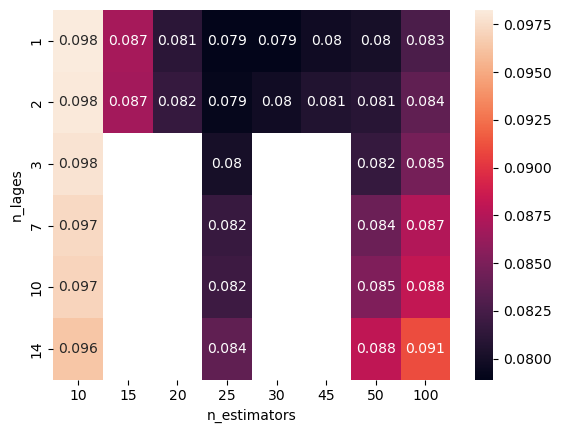

In [35]:
import seaborn as sns
tune_res_ct = pd.crosstab(tune_res_3.n_lages, tune_res_3.n_estimators, values=tune_res_3.MAPE,aggfunc='mean')
sns.heatmap(tune_res_ct, annot=True)

<AxesSubplot:xlabel='n_estimators', ylabel='n_lages'>

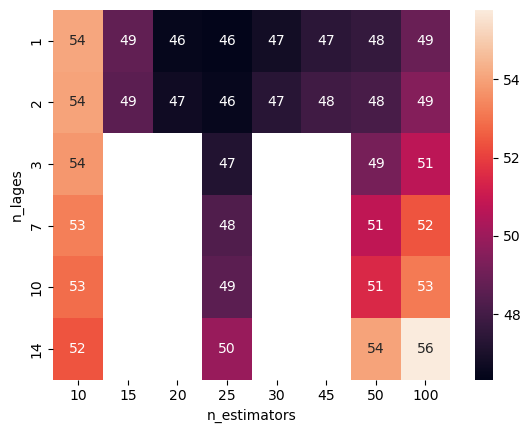

In [36]:
import seaborn as sns
tune_res_ct = pd.crosstab(tune_res_3.n_lages, tune_res_3.n_estimators, values=tune_res_3.RMSE,aggfunc='mean')
sns.heatmap(tune_res_ct, annot=True)

<AxesSubplot:xlabel='n_estimators', ylabel='n_lages'>

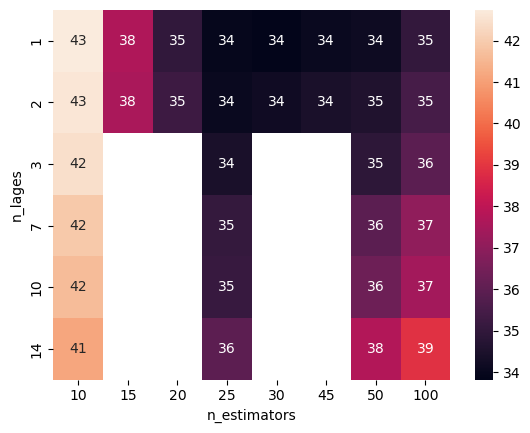

In [37]:
import seaborn as sns
tune_res_ct = pd.crosstab(tune_res_3.n_lages, tune_res_3.n_estimators, values=tune_res_3.MAE,aggfunc='mean')
sns.heatmap(tune_res_ct, annot=True)